In [1]:
import torch
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Hyperparameters
grid_size = 200  # Start with a smaller grid size
total_iterations = 600

In [3]:
# Reaction-Diffusion parameters 
pa = 0.5
pb = 0.8
pe = 2.6
d = 30
dt = 1e-1
threshold = 1
gamma = 625
ph = 1
amax = 60  # activator limiter
smax = 80  # suppressor limiter
width = 0.4  # width of dendrites (1 for normal)

In [4]:
# Initial conditions for u, v, c, and n as PyTorch tensors
u = torch.zeros((grid_size, grid_size), device=device)
v = torch.zeros((grid_size, grid_size), device=device)
c = torch.zeros((grid_size, grid_size), device=device)

u_new = torch.zeros_like(u)
v_new = torch.zeros_like(v)
c_new = torch.zeros_like(c)

# Nutrient landscape
mid = grid_size // 2
n = torch.ones((grid_size, grid_size), device=device)
n[:, mid:] = 0.3

# Rocks (obstacles) on substrate that spawn randomly
num_rocks = 50
max_rock_size = 10
exclusion_zone = 20
torch.manual_seed(torch.seed())

In [6]:
for _ in range(num_rocks):
    rock_size = torch.randint(1, max_rock_size, (1,)).item()
    x = torch.randint(rock_size, grid_size - rock_size, (1,)).item()
    y = torch.randint(rock_size, grid_size - rock_size, (1,)).item()

    # Check if the rock is in the exclusion zone
    if abs(x - mid) > (exclusion_zone + rock_size) and abs(y - mid) > (exclusion_zone + rock_size):
        n[x - rock_size:x + rock_size, y - rock_size:y + rock_size] = 0

# Initial activator and suppressor states
for k in range(-6, 7):
    u[mid-6:mid+7, mid-6:mid+7] = 0.5 + torch.rand((13, 13), device=device) / 100
    v[mid-6:mid+7, mid-6:mid+7] = 0.1 + torch.rand((13, 13), device=device) / 100
    c[mid-6:mid+7, mid-6:mid+7] = 1
    
    ij_mat = torch.zeros((grid_size,grid_size)).to(device)

In [7]:
# Function for updating visualizations
def update_visualization(step, u, v, c, n):
    plt.subplot(2, 2, 1)
    plt.imshow(u.cpu().numpy(), cmap='jet', vmin=0, vmax=amax)
    plt.title(f'Activator u at iteration {step}')
    plt.colorbar()
    
    plt.subplot(2, 2, 2)
    plt.imshow(v.cpu().numpy(), cmap='jet', vmin=0, vmax=smax)
    plt.title(f'Suppressor v at iteration {step}')
    plt.colorbar()

    plt.subplot(2, 2, 3)
    plt.imshow(c.cpu().numpy(), cmap='jet', vmin=-1, vmax=1)
    plt.title(f'Mycelium at iteration {step}')
    plt.colorbar()

    plt.subplot(2, 2, 4)
    plt.imshow(n.cpu().numpy(), cmap='jet')
    plt.title('Substrate')
    plt.colorbar()

    plt.tight_layout()
    plt.draw()
    plt.pause(0.01)
    plt.clf()

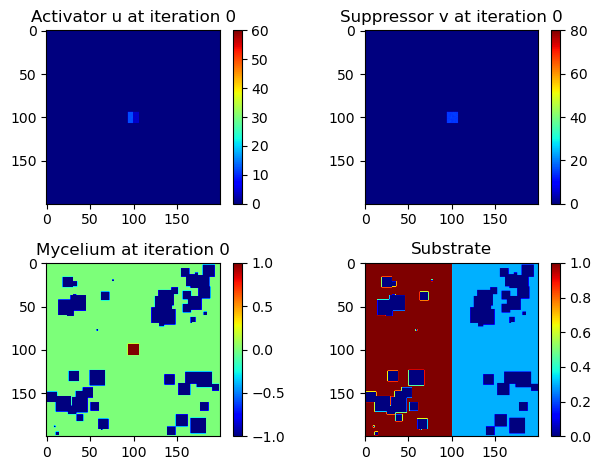

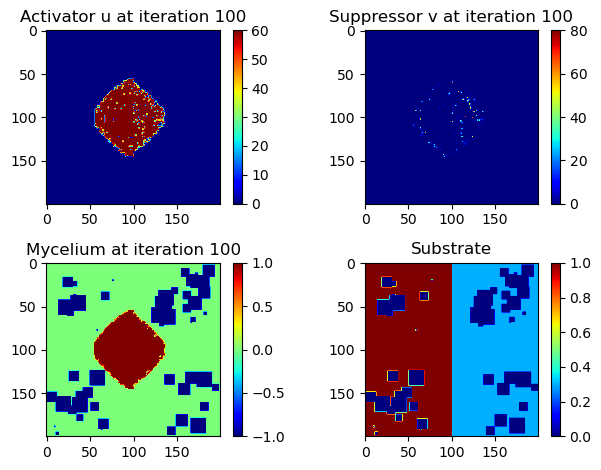

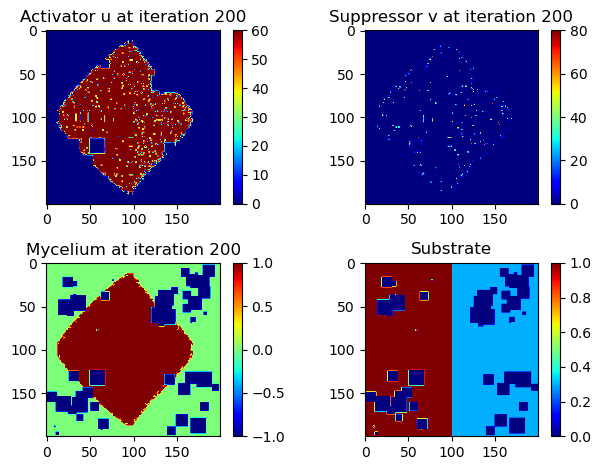

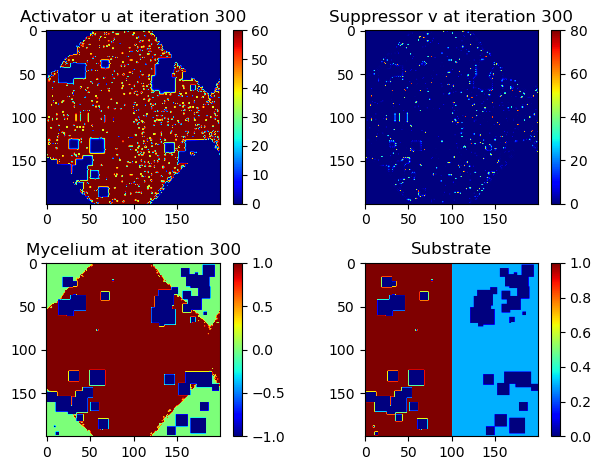

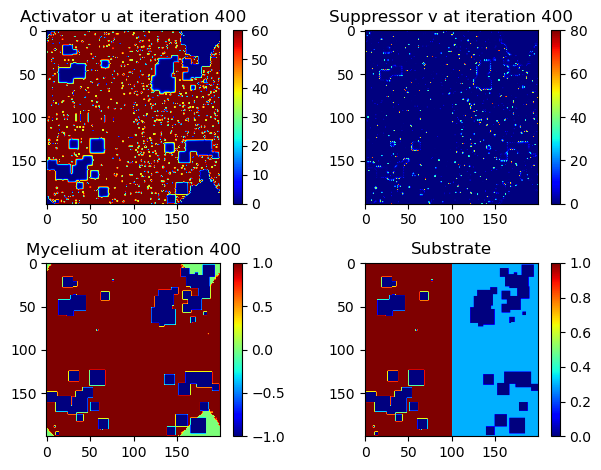

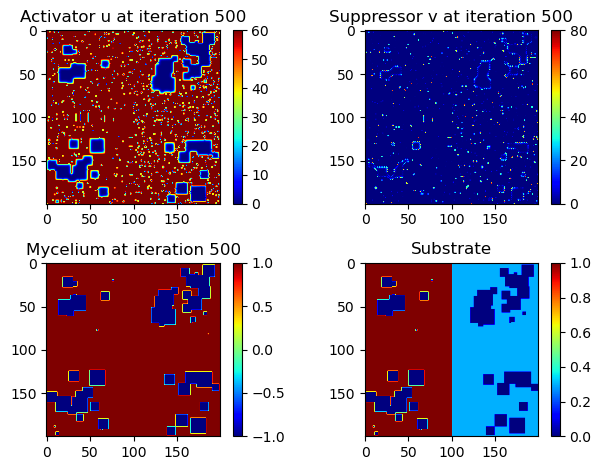

<Figure size 640x480 with 0 Axes>

In [8]:
for step in range(total_iterations):
    # Reaction Terms that control chemical behavior
    f_uv = width * (pa * u + u ** 2 - pb * u * v) * n
    g_uv = pe * u ** 3 - v

    # Incorporate the radius of the plasmatic membrane
    ij_mat = torch.zeros_like(ij_mat)  # Reset each iteration
    ij_mat[c > 0.5] = 1  # Fill ij_mat based on the mycelium matrix

    # Update activator and suppressor
    v_new = v + dt * (d * (0.05 * (torch.roll(v, 1, 0) + torch.roll(v, -1, 0) +
                                    torch.roll(v, 1, 1) + torch.roll(v, -1, 1)) - 0.2 * v) + gamma * g_uv)
    u_new = u + dt * (0.05 * (torch.roll(u, 1, 0) + torch.roll(u, -1, 0) +
                              torch.roll(u, 1, 1) + torch.roll(u, -1, 1)) - 0.2 * u + gamma * f_uv)

    # Apply threshold and adjust alpha
    alpha = torch.where(u <= threshold, 0.49, 0.49 - 2.5 * (u - threshold))
    v_new[u > threshold] = 0

    # Update c using alpha and apply limits
    c_new = c + dt * (gamma * ph * c * (alpha - c) * (c - 1))
    c_new = torch.where(alpha < 0, torch.ones_like(c_new), c_new)
    c_new[n == 0] = -1

    # Limiters of activator and suppressor to avoid exponential growth
    u_new = torch.clamp(u_new, 0, amax)
    v_new = torch.clamp(v_new, 0, smax)

    # Update variables
    u, v, c = u_new, v_new, c_new

    # Visualization every 100 steps
    if step % 100 == 0:
        update_visualization(step, u, v, c, n)